In [1]:
import importlib

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import sympy as sm
import sympy.physics.mechanics as me

import robot
from integrate import integrate_eom
import interpolation


%config InlineBackend.figure_formats = ['svg']
me.functions.mechanics_printing(use_latex="mathjax", latex_mode="equation")

In [2]:
importlib.reload(robot)
importlib.reload(interpolation)

r = robot.SerialRobot()

physical_params = {
    r.g: 9.8,  # Gravity
    r.la: 1,  # The first link length.
    r.lb: 0.2,  # The second link length.
    r.ma: 1,  # The mass of the first link.
    r.mb: 5,  # The mass of the second link.
    r.Ia: 1,  # The moment of inertia of the first link.
    r.Ib: 5,  # The moment of inertia of the second link.
}

### Is a jumping possible using the hip joint instead of the toe joint?
- Yes, it is.
- Should I try a fast snap? Yes.
    1. From negative $\theta_2$ to 0.
    2. From positive $\theta_2$ to 0.
- I think it is sensible to make joint angle acceleration continuous since the lift-off condition is sensitive to the joint accelerations.
    - Or should I say that the generalized force $u_x$ is a continuous function of joint angles accelerations.
    - In physical implementations using electric motors, I think accelerations can only be adjusted continuously.
    - Adopting piecewise constants jerks, the interpolation would be C2 continuous.
        - Use `interpolation.path_jerk`.
    - The generalized force $u_x$ would be continuous too.
    - But I guess it still requires multiple segments for `scipy.integreate.solve_ivp'.
- Is it true that if `t_eval` is specified, the terminal point will not be included when the terminal condition is found?
    - Should I execute an additional integration to include it?

In [3]:
# The toe joint remains fully contracted.
def ref_x(_):
    return 0.


def ref_dx(_):
    return 0.


def ref_ddx(_):
    return 0.

#### Stage 1: before the lift-off.
- In this stage of motions, $x(t) = 0$ and $\theta_2(t)$ is extending fast.
- The dashed vertical line indicates the moment of lift-off.

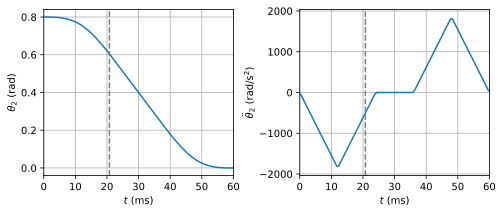

In [4]:
ms = 1e-3
tf = 60 * ms
n = 5
knots = np.linspace(0, tf, n + 1)
ss, vels, accs, jerks = interpolation.path_jerk(knots)

constraints = [
    vels[0] == 0, ss[0] == 0.8,
    vels[-1] == 0, ss[-1] == 0.,
]
# prob = cp.Problem(cp.Minimize(cp.sum(cp.abs(accs[1:] - accs[:-1])) +
#                               cp.sum(accs**2) * 0.02 +
#                               cp.sum(cp.abs(vels)) * 10),
#                               constraints)
prob = cp.Problem(cp.Minimize(cp.sum(cp.abs(accs))), constraints)
prob.solve()


def ref_th2(t):
    return interpolation.pos(t, knots, ss, vels, accs, jerks)


def ref_dth2(t):
    return interpolation.vel(t, knots, ss, vels, accs, jerks)


def ref_ddth2(t):
    return interpolation.acc(t, knots, ss, vels, accs, jerks)


fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=0.35)

int_ts = np.linspace(0, tf, 101)

ax.plot(int_ts / ms, [ref_th2(t) for t in int_ts])
ax.set_xlabel(r'$t$ (ms)')
ax.set_ylabel(r'$\theta_2$ (rad)')
ax.grid()

a, b = np.min(ss.value), np.max(ss.value)
ymin, ymax = 1.05 * a - 0.05 * b, 1.05 * b - 0.05 * a
ax.vlines([20.777], ymin=ymin, ymax=ymax,
           color='grey', linestyles='--')

ax.set_xlim(0, tf / ms)
ax.set_ylim(ymin, ymax)

mid_ts = (int_ts[:-1] + int_ts[1:]) / 2
ax2.plot(mid_ts / ms, [ref_ddth2(t) for t in mid_ts])
ax2.set_xlabel(r'$t$ (ms)')
ax2.set_ylabel(r'$\ddot{\theta}_2$ (rad/s$^2$)')
ax2.grid()
ax2.set_xlim(0, tf / ms)

a, b = np.min(accs.value), np.max(accs.value)
ymin, ymax = 1.05 * a - 0.05 * b, 1.05 * b - 0.05 * a
ax2.set_ylim(ymin, ymax)
ax2.vlines([20.751], ymin=ymin, ymax=ymax,
           color='grey', linestyles='--')


In [5]:
# In this example, ddth2, ddx are given,
# uth2 and ux can be calculated from them.
sol = sm.solve(
    r.eom.subs(physical_params),
    [r.ddth1, r.uth2, r.ux],
)

- The generalized force $u_x$ gives the lift-off condition.

In [6]:
def f(t, y):
    """
    Calculates dy/dt for given ddth2(t) and ddx(t).

    Parameters
    ----------
    t (float): Time.
    y (ndarray): The state vector y = (th1, th2, x, dth1, dth2, dx).

    Returns
    -------
    (ndarray): dy/dt = (dth1, dth2, dx, ddth1, ddth2, ddx).
    """
    return np.concatenate([
        y[3:],
        [float(me.msubs(
            sol[r.ddth1],
            {k: v for k, v in zip(r.state_vec, y)},
            {r.ddth2: ref_ddth2(t), r.ddx: ref_ddx(t)},
            ))],
        [ref_ddth2(t), ref_ddx(t)],
    ])


def liftoff_event(t, y):
    """
    A negative generalized force for x is not attainable.
    It sifnifies a lift-off.

    Parameters
    ----------
    t (float): Time
    y (ndarray): The state vector y = (th1, th2, x, dth1, dth2, dx).
    """
    return float(me.msubs(
        sol[r.ux],
        {k: v for k, v in zip(r.state_vec, y)},
        {r.ddth2: ref_ddth2(t), r.ddx: ref_ddx(t)}))


liftoff_event.terminal = True
# The negative u2 indicates an contraction force, which is not attainable.
liftoff_event.direction = -1.

In [7]:
init_th1 = 0.15
init_dth1 = 0

y0 = np.asarray([init_th1, ref_th2(knots[0]), ref_x(knots[0]),
                 init_dth1, ref_dth2(knots[0]), ref_dx(knots[0])])
xs, ys = integrate_eom(f, y0, knots, np.linspace(0, tf, 81), liftoff_event)

terminal @ 20.907 (ms).


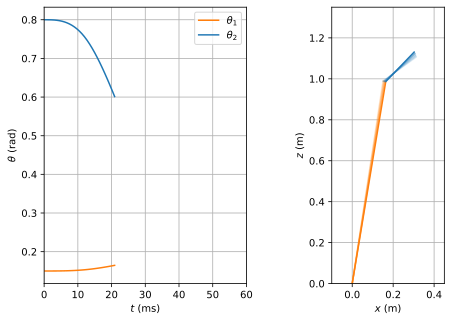

In [8]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 5))

ms = 1e-3
ax.plot(xs / ms, ys[0], label=r'$\theta_1$', c='C1')
ax.plot(xs / ms, ys[1], label=r'$\theta_2$', c='C0')

ax.legend()
ax.grid()
ax.set_xlabel(r'$t$ (ms)')
ax.set_ylabel(r'$\theta$ (rad)')

ax.set_xlim(0, tf / ms)


def draw_motions(ax):
    len_a = physical_params[r.la]
    len_b = physical_params[r.lb]
    
    alphas = np.exp((xs - xs[-1]) / (xs[-1] - xs[0]) * 4)

    for (th1, th2, *_), alpha in zip(ys.T[::-4], alphas[::-4]):
        ax.plot([0, len_a * np.sin(th1)],
                [0, len_a * np.cos(th1)],
                c='C1', alpha=alpha)
        ax.plot([len_a * np.sin(th1), len_a * np.sin(th1) + len_b * np.sin(th1 + th2)],
                [len_a * np.cos(th1), len_a * np.cos(th1) + len_b * np.cos(th1 + th2)],
                c='C0', alpha=alpha)
    
    ax.grid()
    
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x$ (m)')
    ax.set_ylabel(r'$z$ (m)')
    
    ax.set_xlim(-0.1, 0.45)
    ax.set_ylim(0, 1.35)


draw_motions(ax2)

Text(0, 0.5, '$u_x$ (N)')

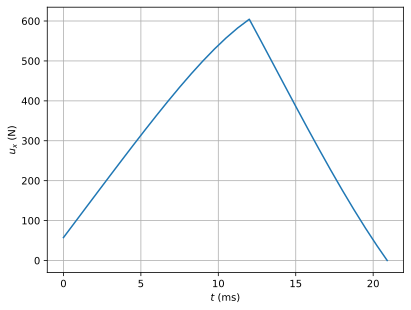

In [9]:
fig, ax = plt.subplots()

ax.plot(xs / ms, [liftoff_event(t, y) for t, y in zip(xs, ys.T)])

ax.grid()
ax.set_xlabel(r'$t$ (ms)')
ax.set_ylabel(r'$u_x$ (N)')


In [10]:
subs_dir = {k: v for k, v in zip(r.state_vec, ys[:, -1])}

q1 = float(me.msubs(r.Pa.pos_from(r.O).dot(r.N.x).subs(physical_params), subs_dir))
q2 = float(me.msubs(r.Pa.pos_from(r.O).dot(r.N.z).subs(physical_params), subs_dir))


dq1 = float(me.msubs(r.Pa.vel(r.N).dot(r.N.x).subs(physical_params), subs_dir))
dq2 = float(me.msubs(r.Pa.vel(r.N).dot(r.N.z).subs(physical_params), subs_dir))

th1, th2, dth1, dth2 = ys[[0, 1, 3, 4], -1]

# The initial state of the second stage.
y1 = np.asarray([q1, q2, th1, th2, dq1, dq2, dth1, dth2])

# The initial and final times for the second stage.
ti, tf = xs[-1], 500 * ms

# It keeps the remaining knots of the earlier stage.
knots1 = np.concatenate([
    [ti,],
    knots[knots >ti],
    [tf,],
])

#### Step 2: After the lift-off.
- $\theta_2(t)$ is specified for this stage of motions.
    - Actually, $\theta_2(t)$ is calculated for given $\theta_2(0)$, and $\dot{\theta}_2(0)$, and $\ddot{\theta}_2(t)$.
- $x(t)$ is a SymPy dynamic symbol but is a kinematic variable since the mass of the link related $x$ is zero.
- The state vector $y = (q_1, q_2, \theta_1, \theta_2, \dot{q}_1, \dot{q}_2, \dot{\theta}_1, \dot{\theta}_2)$.
- Only one actuation $u_{\theta_2}$.

In [11]:
r2 = robot.FlyingRobot()

# uth2 can be calculated for a given ddth2.
sol_r2 = sm.solve(
    r2.eom.subs(physical_params),
    [r2.ddq1, r2.ddq2, r2.ddth1, r2.uth2],
)

sol_r2 = {k: v.simplify().trigsimp() for k, v in sol_r2.items()}

In [12]:
t_eval = np.linspace(knots1[0], knots1[-1], 201)


def f(t, y):
    """
    Calculate (dq1, dq2, dth1, dth2, ddq1, ddq2, ddth1, ddth2).

    Parameters
    ----------
    t (float): Time.
    y (ndarray): A state vector of the robot. The shape of (8,).
    """
    ath2 = ref_ddth2(t)

    return np.asarray([
        y[4], y[5], y[6], y[7],
        float(me.msubs(sol_r2[r2.ddq1], {k: v for k, v in zip(r2.state_vec, y)}).subs({r2.ddth2: ath2})),
        float(me.msubs(sol_r2[r2.ddq2], {k: v for k, v in zip(r2.state_vec, y)}).subs({r2.ddth2: ath2})),
        float(me.msubs(sol_r2[r2.ddth1], {k: v for k, v in zip(r2.state_vec, y)}).subs({r2.ddth2: ath2})),
        ath2,
    ])


def touchdown_event(t, y):
    return float(me.msubs(r2.Pe.pos_from(r2.O).dot(r2.N.z).subs(physical_params),
                          {k: v for k, v in zip(r2.state_vec, y)},
                          {r2.x: ref_x(t)}))


touchdown_event.terminal = True
touchdown_event.direction = -1

xs1, ys1 = integrate_eom(f, y1, knots1, t_eval, touchdown_event)

terminal @ 151.514 (ms).


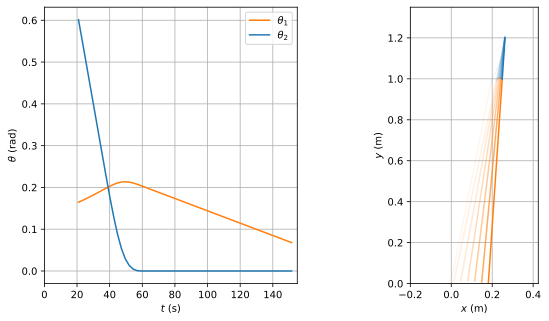

In [13]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax.plot(xs1 / ms, ys1[2], label=r'$\theta_1$', c='C1')
ax.plot(xs1 / ms, ys1[3], label=r'$\theta_2$', c='C0')

ax.legend()
ax.grid()

ax.set_xlabel(r'$t$ (s)')
ax.set_ylabel(r'$\theta$ (rad)')

ax.set_xlim(0, 155)


def draw_motions(ax):
    len_a = physical_params[r2.la]
    len_b = physical_params[r2.lb]

    alphas = np.exp((xs1 - xs1[-1]) / (xs1[-1] - xs1[0]) * 3)

    for (q1, q2, th1, th2, *_), alpha in zip(ys1.T[::-8], alphas[::-8]):
        ax.plot([q1 - len_a / 2 * np.sin(th1), q1 + len_a / 2 * np.sin(th1)],
                [q2 - len_a / 2 * np.cos(th1), q2 + len_a / 2 * np.cos(th1)],
                c='C1', alpha=alpha)
        ax.plot([q1 + len_a / 2 * np.sin(th1), q1 + len_a / 2 * np.sin(th1) + len_b * np.sin(th1 + th2)],
                [q2 + len_a / 2 * np.cos(th1), q2 + len_a / 2 * np.cos(th1) + len_b * np.cos(th1 + th2)],
                c='C0', alpha=alpha)
    
    ax.grid()
    
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x$ (m)')
    ax.set_ylabel(r'$y$ (m)')
    
    ax.set_xlim(-0.2, 0.425)
    ax.set_ylim(0, 1.35)


draw_motions(ax2)

- Even though it is a fast motion of $\theta_2$, the amount of the air time is quite small.
- This example shows that a jump using negative $\dot{\theta}_2$ produces the negative $\dot{\theta}_1$ in the mid-air once $\theta_2$ and $\dot{\theta}_2$ become 0.
- For a stable landing, a negative $\dot{\theta}_1$ might be necessary since $\dot{\theta}_1$ need to slow down after landing.

### Jumping using the toe joint.
- A full extension of the toe joint is 10 cm.
    - Do I need a full extension?

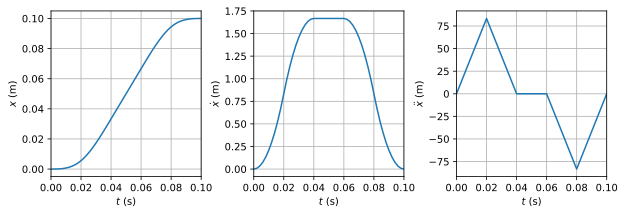

In [14]:
tf = 100 * ms
n = 5
knots = np.linspace(0, tf, n + 1)
ss, vels, accs, jerks = interpolation.path_jerk(knots)

constraints = [
    vels[0] == 0, ss[0] == 0.,
    vels[-1] == 0, ss[-1] == 0.1,
]

prob = cp.Problem(cp.Minimize(cp.sum(cp.abs(accs))), constraints)
prob.solve()


def ref_x(t):
    return interpolation.pos(t, knots, ss, vels, accs, jerks)


def ref_dx(t):
    return interpolation.vel(t, knots, ss, vels, accs, jerks)


def ref_ddx(t):
    return interpolation.acc(t, knots, ss, vels, accs, jerks)


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
plt.subplots_adjust(wspace=0.35)

int_ts = np.linspace(0, tf, 51)
ax.plot(int_ts, [interpolation.pos(t, knots, ss, vels, accs, jerks) for t in int_ts])

ax.set_ylabel(r'$x$ (m)')
ax2.set_ylabel(r'$\dot{x}$ (m)')
ax3.set_ylabel(r'$\ddot{x}$ (m)')

ax2.plot(int_ts, [interpolation.vel(t, knots, ss, vels, accs, jerks) for t in int_ts])

ax3.plot(int_ts, [interpolation.acc(t, knots, ss, vels, accs, jerks) for t in int_ts])

for a in [ax, ax2, ax3]:
    a.grid()
    a.set_xlabel(r'$t$ (s)')
    a.set_xlim(0, tf)


In [15]:
# th2 does not move at all.
def ref_th2(_):
    return 0.8


def ref_dth2(_):
    return 0


def ref_ddth2(_):
    return 0

In [16]:
def f(t, y):
    """
    It assumes that u_{\theta_2} = 0, which is the actuation for the \theta_2.

    Parameters
    ----------
    t (float): Time.
    y (ndarray): The state vector y = (th1, th2, x, dth1, dth2, dx).
    """
    return np.concatenate([
        y[3:],
        [float(me.msubs(
            sol[r.ddth1],
            {k: v for k, v in zip(r.state_vec, y)},
            {r.ddth2: ref_ddth2(t), r.ddx: ref_ddx(t)},
            ))],
        [ref_ddth2(t), ref_ddx(t)],
    ])


def liftoff_event(t, y):
    """
    A negative generalized force for x is not attainable.

    Parameters
    ----------
    t (float): Time
    y (ndarray): The state vector y = (th1, th2, x, dth1, dth2, dx).
    """
    return float(me.msubs(
        sol[r.ux],
        {k: v for k, v in zip(r.state_vec, y)},
        {r.ddth2: ref_ddth2(t), r.ddx: ref_ddx(t)}))


liftoff_event.terminal = True
# The negative u2 indicates an contraction force, which is not attainable.
liftoff_event.direction = -1.

In [17]:
t_eval = np.linspace(0, tf, 81)

init_th1 = 0.15
init_dth1 = 0

y0 = np.asarray([init_th1, ref_th2(knots[0]), ref_x(knots[0]),
                 init_dth1, ref_dth2(knots[0]), ref_dx(knots[0])])

xs, ys = integrate_eom(f, y0, knots, t_eval, liftoff_event)

terminal @ 62.301 (ms).


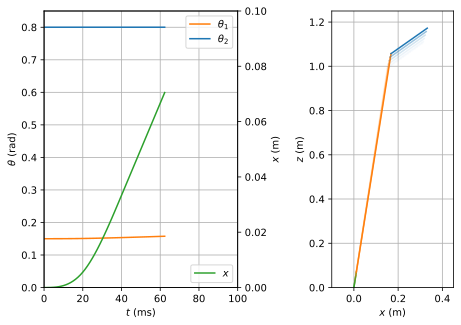

In [18]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 5))
plt.subplots_adjust(wspace=0.3)

ax.plot(xs / ms, ys[0], label=r'$\theta_1$', c='C1')
ax.plot(xs / ms, ys[1], label=r'$\theta_2$', c='C0')

ax.legend()
ax.grid()
ax.set_xlabel(r'$t$ (ms)')
ax.set_ylabel(r'$\theta$ (rad)')

ax.set_xlim(0, tf / ms)
ax.set_ylim(0, 0.85)

tax = ax.twinx()
tax.plot(xs / ms, ys[2], label=r'$x$', c='C2')
tax.set_ylabel(r'$x$ (m)')
tax.set_ylim(0, 0.1)

tax.legend(loc='lower right')


def draw_motions(ax):
    len_a = physical_params[r.la]
    len_b = physical_params[r.lb]
    
    alphas = np.exp((xs - xs[-1]) / (xs[-1] - xs[0]) * 5)

    for (th1, th2, x, *_), alpha in zip(ys.T[::-8], alphas[::-8]):
        # th1_val, th2_val, *_ = y

        # len_a, len_b = physical_params[la], physical_params[lb]
        p_x = [x * np.sin(th1), x * np.cos(th1)]
        p_a = [(len_a + x) * np.sin(th1),
            (len_a + x) * np.cos(th1)]
        p_b = [(len_a + x) * np.sin(th1) + len_b * np.sin(th1 + th2),
            (len_a + x) * np.cos(th1) + len_b * np.cos(th1 + th2)]

        ax.plot([0, p_x[0]], [0, p_x[1]], c='C2', alpha=alpha)
        ax.plot([p_x[0], p_a[0]], [p_x[1], p_a[1]], c='C1', alpha=alpha)
        ax.plot([p_a[0], p_b[0]], [p_a[1], p_b[1]], c='C0', alpha=alpha)
    
    ax.grid()
    
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x$ (m)')
    ax.set_ylabel(r'$z$ (m)')
    
    ax.set_xlim(-0.1, 0.45)
    ax.set_ylim(0, 1.25)


draw_motions(ax2)

(0.0, 100.0)

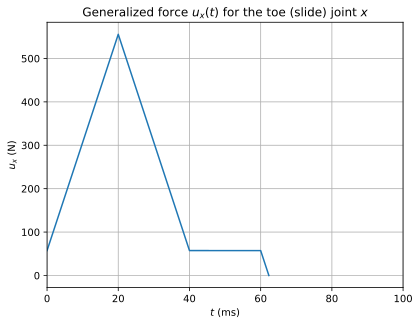

In [19]:
fig, ax = plt.subplots()

ax.plot(xs / ms, [liftoff_event(t, y) for t, y in zip(xs, ys.T)])

ax.grid()

ax.set_xlabel(r'$t$ (ms)')
ax.set_ylabel(r'$u_x$ (N)')
ax.set_title(r'Generalized force $u_x(t)$ for the toe (slide) joint $x$')
ax.set_xlim(knots[0] / ms, knots[-1] / ms)


- One thing to know in this experiment is that the toe push does not introduce a significant change of $\dot{\theta}_1$.

In [20]:
subs_dir = {k: v for k, v in zip(r.state_vec, ys[:, -1])}

q1 = float(me.msubs(r.Pa.pos_from(r.O).dot(r.N.x).subs(physical_params),
                    subs_dir))
q2 = float(me.msubs(r.Pa.pos_from(r.O).dot(r.N.z).subs(physical_params),
                    subs_dir))

dq1 = float(me.msubs(r.Pa.vel(r.N).dot(r.N.x).subs(physical_params),
                     subs_dir))
dq2 = float(me.msubs(r.Pa.vel(r.N).dot(r.N.z).subs(physical_params),
                     subs_dir))

th1, th2, dth1, dth2 = ys[[0, 1, 3, 4], -1]

y1 = np.asarray([q1, q2, th1, th2, dq1, dq2, dth1, dth2])
ti, tf = xs[-1], 500 * ms

# It keeps the knots of the early stage, where the path is not smooth.
knots1 = np.concatenate([
    [ti,],
    knots[knots >ti],
    [tf,],
])

In [21]:
r2 = robot.FlyingRobot()

sol_r2 = sm.solve(
    r2.eom.subs(physical_params),
    [r2.ddq1, r2.ddq2, r2.ddth1, r2.uth2],
)

sol_r2 = {k: v.simplify().trigsimp() for k, v in sol_r2.items()}

In [22]:
t_eval = np.linspace(knots1[0], knots1[-1], 81)


def f(t, y):
    """
    Calculate (dq1, dq2, dth1, dth2, ddq1, ddq2, ddth1, ddth2).

    Parameters
    ----------
    t (float): Time.
    y (ndarray): A state vector of the robot. The shape of (8,).
    """
    ath2 = ref_ddth2(t)

    return np.asarray([
        y[4], y[5], y[6], y[7],
        float(me.msubs(sol_r2[r2.ddq1], {k: v for k, v in zip(r2.state_vec, y)}).subs({r2.ddth2: ath2})),
        float(me.msubs(sol_r2[r2.ddq2], {k: v for k, v in zip(r2.state_vec, y)}).subs({r2.ddth2: ath2})),
        float(me.msubs(sol_r2[r2.ddth1], {k: v for k, v in zip(r2.state_vec, y)}).subs({r2.ddth2: ath2})),
        ath2,
    ])


def touchdown_event(t, y):
    return float(me.msubs(r2.Pe.pos_from(r2.O).dot(r2.N.z).subs(physical_params),
                          {k: v for k, v in zip(r2.state_vec, y)},
                          {r2.x: ref_x(t)}))

touchdown_event.terminal = True
touchdown_event.direction = -1

xs1, ys1 = integrate_eom(f, y1, knots1, t_eval, touchdown_event)


terminal @ 378.738 (ms).


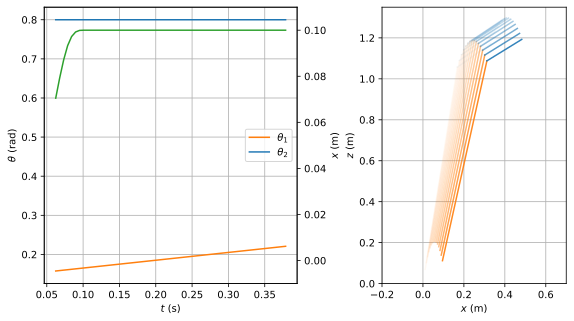

In [23]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax.plot(xs1, ys1[2], label=r'$\theta_1$', c='C1')
ax.plot(xs1, ys1[3], label=r'$\theta_2$', c='C0')

ax.legend()
ax.grid()

ax.set_xlabel(r'$t$ (s)')
ax.set_ylabel(r'$\theta$ (rad)')

tax = ax.twinx()
tax.plot(xs1, [ref_x(t) for t in xs1], c='C2')

tax.set_ylabel(r'$x$ (m)')
tax.set_ylim(-0.01, 0.11)


def draw_motions(ax):
    len_a = physical_params[r2.la]
    len_b = physical_params[r2.lb]
    
    # ax.plot([y[0] for y in ys], [y[1] for y in ys])
    alpha = 1.
    alphas = np.exp((xs1 - xs1[-1]) / (xs1[-1] - xs1[0]) * 3)
    
    for (q1, q2, th1, th2, *_), alpha in zip(ys1[:, ::4].T, alphas[::4]):
        ax.plot([q1 - len_a / 2 * np.sin(th1), q1 + len_a / 2 * np.sin(th1)],
                [q2 - len_a / 2 * np.cos(th1), q2 + len_a / 2 * np.cos(th1)],
                c='C1', alpha=alpha)
        ax.plot([q1 + len_a / 2 * np.sin(th1), q1 + len_a / 2 * np.sin(th1) + len_b * np.sin(th1 + th2)],
                [q2 + len_a / 2 * np.cos(th1), q2 + len_a / 2 * np.cos(th1) + len_b * np.cos(th1 + th2)],
                c='C0', alpha=alpha)
    
    ax.grid()
    
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x$ (m)')
    ax.set_ylabel(r'$z$ (m)')
    
    ax.set_xlim(-0.2, 0.7)
    ax.set_ylim(0, 1.35)


draw_motions(ax2)

- A jumping using $x$ does not produce a significan momentum of $\theta_1$.
- To control the body orientation in the mid-air, nonzero $\dot{\theta}_2$ might be necessary.

### Soft-landing and lift-off
- They might be mirror images between them.
- You can give an argument with the time-reversal symmetry of the classical equations of motion.

### Using both of the hip joint and the toe joint.
- Extending $x$ joint.
- Non-zero $\dot{\theta}_2$ at the moment of a lift-off.

#### Before the lift-off.

(0.0, 100.0)

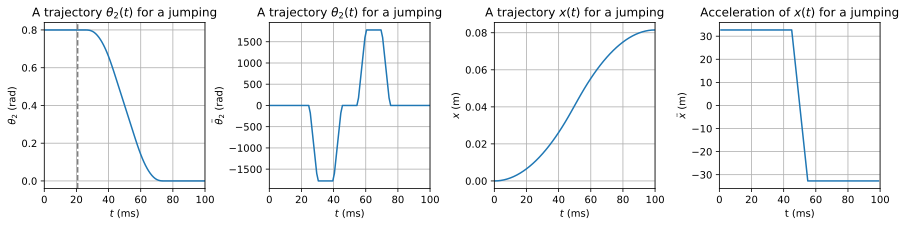

In [24]:
def gen_ref_traj(tf, n):
    def gen_ref_th2():
        knots = np.linspace(0, tf, n + 1)
        ss, vels, accs, jerks = interpolation.path_jerk(knots)

        initial_th2 = 0.8

        constraints = [
            vels[0] == 0, ss[0] == initial_th2,
            vels[5] == 0, ss[5] == initial_th2,
            # vels[7] == 0, ss[7] == 0.0,
            vels[-6] == 0, ss[-6] == 0,
            vels[-1] == 0, ss[-1] == 0,
        ]

        prob = cp.Problem(cp.Minimize(cp.sum(cp.abs(accs)) + cp.sum(cp.abs(jerks) * 0.01)), constraints)
        prob.solve()

        def ref_th2(t):
            if t > tf:
                return 0

            return interpolation.pos(t, knots, ss, vels, accs, jerks)


        def ref_dth2(t):
            if t > tf:
                return 0

            return interpolation.vel(t, knots, ss, vels, accs, jerks)


        def ref_ddth2(t):
            if t > tf:
                return 0

            return interpolation.acc(t, knots, ss, vels, accs, jerks)
        
        return ref_th2, ref_dth2, ref_ddth2


    def gen_ref_x():
        knots = np.linspace(0, tf, n + 1)
        ss, vels, accs, jerks = interpolation.path_jerk(knots)

        final_x = 0.0815

        constraints = [
            vels[0] == 0, ss[0] == 0.,
            vels[-1] == 0, ss[-1] == final_x,
        ]
        prob = cp.Problem(cp.Minimize(cp.sum(cp.abs(jerks))), constraints)
        prob.solve()

        def ref_x(t):
            if t > tf:
                return final_x

            return interpolation.pos(t, knots, ss, vels, accs, jerks)


        def ref_dx(t):
            if t > tf:
                return 0

            return interpolation.vel(t, knots, ss, vels, accs, jerks)


        def ref_ddx(t):
            if t > tf:
                return 0

            return interpolation.acc(t, knots, ss, vels, accs, jerks)
        
        return ref_x, ref_dx, ref_ddx


    ref_th2, ref_dth2, ref_ddth2 = gen_ref_th2()
    ref_x, ref_dx, ref_ddx = gen_ref_x()

    knots = np.linspace(0, tf, n + 1)

    return (knots,
            ref_th2, ref_dth2, ref_ddth2,
            ref_x, ref_dx, ref_ddx)


ms = 1e-3
tf = 100 * ms

(knots,
 ref_th2, ref_dth2, ref_ddth2,
 ref_x, ref_dx, ref_ddx) = gen_ref_traj(tf, 20)

fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3))
plt.subplots_adjust(wspace=0.4)

int_ts = np.linspace(0, tf, 101)

int_th2 = [ref_th2(t) for t in int_ts]
ax.plot(int_ts / ms, int_th2)
ax.set_title(r'A trajectory $\theta_2(t)$ for a jumping')
ax.set_xlabel(r'$t$ (ms)')
ax.set_ylabel(r'$\theta_2$ (rad)')
ax.grid()

a, b = np.min(int_th2), np.max(int_th2)
ymin, ymax = 1.05 * a - 0.05 * b, 1.05 * b - 0.05 * a
ax.vlines([20.777], ymin=ymin, ymax=ymax,
           color='grey', linestyles='--')

ax.set_xlim(0, tf / ms)
ax.set_ylim(ymin, ymax)

mid_ts = (int_ts[:-1] + int_ts[1:]) / 2
int_ddth2 = [ref_ddth2(t) for t in mid_ts]
ax2.plot(mid_ts / ms, int_ddth2)
ax2.set_title(r'A trajectory $\theta_2(t)$ for a jumping')
ax2.set_xlabel(r'$t$ (ms)')
ax2.set_ylabel(r'$\ddot{\theta}_2$ (rad)')
ax2.grid()
ax2.set_xlim(0, tf / ms)

# a, b = np.min(int_ddth2), np.max(int_ddth2)
# ymin, ymax = 1.05 * a - 0.05 * b, 1.05 * b - 0.05 * a
# ax2.set_ylim(ymin, ymax)
# ax2.vlines([20.751], ymin=ymin, ymax=ymax,
#            color='grey', linestyles='--')

int_ts = np.linspace(0, tf, 51)
ax3.plot(int_ts / ms, [ref_x(t) for t in int_ts])

ax3.grid()

ax3.set_xlabel(r'$t$ (ms)')
ax3.set_ylabel(r'$x$ (m)')
ax3.set_title(r'A trajectory $x(t)$ for a jumping')

ax3.set_xlim(0, tf / ms)

mid_ts = (int_ts[:-1] + int_ts[1:]) / 2
int_ddx = [ref_ddx(t) for t in mid_ts]

ax4.plot(mid_ts / ms, int_ddx)
ax4.grid()

ax4.set_title(r'Acceleration of $x(t)$ for a jumping')
ax4.set_xlabel('t (ms)')
ax4.set_ylabel(r'$\ddot{x}$ (m)')

ax4.set_xlim(0, tf / ms)

In [25]:
def f(t, y):
    """
    It assumes that u_{\theta_2} = 0, which is the actuation for the \theta_2.

    Parameters
    ----------
    t (float): Time.
    y (ndarray): The state vector y = (th1, th2, x, dth1, dth2, dx).
    """
    return np.concatenate([
        y[3:],
        [float(me.msubs(
            sol[r.ddth1],
            {k: v for k, v in zip(r.state_vec, y)},
            {r.ddth2: ref_ddth2(t), r.ddx: ref_ddx(t)},
            ))],
        [ref_ddth2(t), ref_ddx(t)],
    ])


def liftoff_event(t, y):
    """
    A negative generalized force for x is not attainable.

    Parameters
    ----------
    t (float): Time
    y (ndarray): The state vector y = (th1, th2, x, dth1, dth2, dx).
    """
    return float(me.msubs(
        sol[r.ux],
        {k: v for k, v in zip(r.state_vec, y)},
        {r.ddth2: ref_ddth2(t), r.ddx: ref_ddx(t)}))


liftoff_event.terminal = True
# The negative u2 indicates an contraction force, which is not attainable.
liftoff_event.direction = -1.

### Initial $\theta_1$ and $\dot{\theta}_1$ might be a critical parameter.
- With a large $\theta_1$, the body needs to be rotated quite a bit in the mid-air, which might requires a large angular momentum.
- In this example, it is $(0.15, -0.5)$.

In [26]:
init_th1 = 0.1516
init_dth1 = 0.664

y0 = np.asarray([init_th1, ref_th2(knots[0]), ref_x(knots[0]),
                 init_dth1, ref_dth2(knots[0]), ref_dx(knots[0])])
xs, ys = integrate_eom(f, y0, knots, np.linspace(0, tf, 81), liftoff_event)


terminal @ 44.554 (ms).


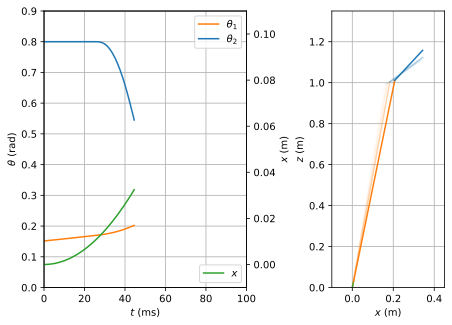

In [27]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 5))


ax.plot(xs / ms, ys[0], label=r'$\theta_1$', c='C1')
ax.plot(xs / ms, ys[1], label=r'$\theta_2$', c='C0')

ax.legend()
ax.grid()
ax.set_xlabel(r'$t$ (ms)')
ax.set_ylabel(r'$\theta$ (rad)')

ax.set_xlim(0, tf / ms)
ax.set_ylim(0, 0.9)

tax = ax.twinx()
tax.plot(xs / ms, ys[2], label=r'$x$', c='C2')

tax.set_ylabel(r'$x$ (m)')
tax.set_ylim(-0.01, 0.11)

tax.legend(loc='lower right')


def draw_motions(ax):
    len_a = physical_params[r.la]
    len_b = physical_params[r.lb]
    
    alphas = np.exp((xs - xs[-1]) / (xs[-1] - xs[0]) * 5)

    for (th1, th2, x, *_), alpha in zip(ys.T[::-8], alphas[::-8]):
        # th1_val, th2_val, *_ = y

        # len_a, len_b = physical_params[la], physical_params[lb]
        p_x = [x * np.sin(th1), x * np.cos(th1)]
        p_a = [(len_a + x) * np.sin(th1),
            (len_a + x) * np.cos(th1)]
        p_b = [(len_a + x) * np.sin(th1) + len_b * np.sin(th1 + th2),
            (len_a + x) * np.cos(th1) + len_b * np.cos(th1 + th2)]

        ax.plot([0, p_x[0]], [0, p_x[1]], c='C2', alpha=alpha)
        ax.plot([p_x[0], p_a[0]], [p_x[1], p_a[1]], c='C1', alpha=alpha)
        ax.plot([p_a[0], p_b[0]], [p_a[1], p_b[1]], c='C0', alpha=alpha)
    
    ax.grid()
    
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x$ (m)')
    ax.set_ylabel(r'$z$ (m)')
    
    ax.set_xlim(-0.1, 0.45)
    ax.set_ylim(0, 1.35)


draw_motions(ax2)

In [28]:
subs_dir = {k: v for k, v in zip(r.state_vec, ys[:, -1])}

q1 = float(me.msubs(r.Pa.pos_from(r.O).dot(r.N.x).subs(physical_params), subs_dir))
q2 = float(me.msubs(r.Pa.pos_from(r.O).dot(r.N.z).subs(physical_params), subs_dir))

dq1 = float(me.msubs(r.Pa.vel(r.N).dot(r.N.x).subs(physical_params), subs_dir))
dq2 = float(me.msubs(r.Pa.vel(r.N).dot(r.N.z).subs(physical_params), subs_dir))

th1, th2, dth1, dth2 = ys[[0, 1, 3, 4], -1]

y1 = np.asarray([q1, q2, th1, th2, dq1, dq2, dth1, dth2])
ti, tf = xs[-1], 500 * ms

# It keeps the knots of the early stage, where the path is not smooth.
knots1 = np.concatenate([
    [ti,],
    knots[knots > ti],
    [tf,],
])

In [29]:
t_eval = np.linspace(knots1[0], knots1[-1], 201)


def f(t, y):
    """
    Calculate (dq1, dq2, dth1, dth2, ddq1, ddq2, ddth1, ddth2).

    Parameters
    ----------
    t (float): Time.
    y (ndarray): A state vector of the robot. The shape of (8,).
    """
    ath2 = ref_ddth2(t)

    return np.asarray([
        y[4], y[5], y[6], y[7],
        float(me.msubs(sol_r2[r2.ddq1], {k: v for k, v in zip(r2.state_vec, y)}).subs({r2.ddth2: ath2})),
        float(me.msubs(sol_r2[r2.ddq2], {k: v for k, v in zip(r2.state_vec, y)}).subs({r2.ddth2: ath2})),
        float(me.msubs(sol_r2[r2.ddth1], {k: v for k, v in zip(r2.state_vec, y)}).subs({r2.ddth2: ath2})),
        ath2,
    ])


def apex_event(t, y):
    return float(me.msubs(r2.Pa.vel(r2.N).dot(r2.N.z).subs(physical_params),
                          {k: v for k, v in zip(r2.state_vec, y)},
                          {r2.x: ref_x(t)}))

apex_event.terminal = True
apex_event.direction = -1

xs1, ys1 = integrate_eom(f, y1, knots1, t_eval, apex_event)

terminal @ 274.618 (ms).


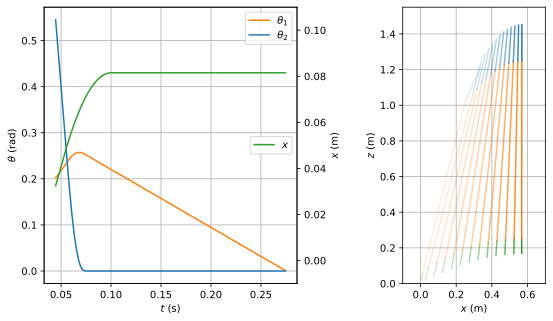

In [30]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax.plot(xs1, ys1[2], label=r'$\theta_1$', c='C1')
ax.plot(xs1, ys1[3], label=r'$\theta_2$', c='C0')

ax.legend(loc='upper right')
ax.grid()

ax.set_xlabel(r'$t$ (s)')
ax.set_ylabel(r'$\theta$ (rad)')

tax = ax.twinx()
tax.plot(xs1, [ref_x(t) for t in xs1], label=r'$x$', c='C2')
tax.set_ylabel('$x$ (m)')
tax.set_ylim(-0.01, 0.11)

tax.legend(loc='center right')


def draw_motions(ax):
    len_a = physical_params[r2.la]
    len_b = physical_params[r2.lb]
    
    # ax.plot([y[0] for y in ys], [y[1] for y in ys])
    alpha = 1.
    alphas = np.exp((xs1 - xs1[-1]) / (xs1[-1] - xs1[0]) * 2)

    for t, (q1, q2, th1, th2, *_), alpha in zip(xs1[::-8], ys1[:, ::-8].T, alphas[::-8]):
        p0 = [q1 - (len_a / 2 + ref_x(t)) * np.sin(th1),
              q2 - (len_a / 2 + ref_x(t)) * np.cos(th1)]
        p1 = [q1 - len_a / 2 * np.sin(th1), q2 - len_a / 2 * np.cos(th1)]
        p2 = [q1 + len_a / 2 * np.sin(th1), q2 + len_a / 2 * np.cos(th1)]
        p3 = [q1 + len_a / 2 * np.sin(th1) + len_b * np.sin(th1 + th2),
              q2 + len_a / 2 * np.cos(th1) + len_b * np.cos(th1 + th2)]
    
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], c='C2', alpha=alpha)
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], c='C1', alpha=alpha)
        ax.plot([p2[0], p3[0]], [p2[1], p3[1]], c='C0', alpha=alpha)

    
    ax.grid()
    
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x$ (m)')
    ax.set_ylabel(r'$z$ (m)')
    
    ax.set_xlim(-0.1, 0.7)
    ax.set_ylim(0, 1.55)


draw_motions(ax2)